In [109]:
from pprint import PrettyPrinter as PrettyPrinter
pp = PrettyPrinter(indent=4)

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import numpy as np
import pylab as pl
import random
from time import time

import twitter

from scipy.cluster.hierarchy import dendrogram, linkage

CONSUMER_KEY = 'FOCsEQzKgiGsmcKjGfIxCMvzG'
CONSUMER_SECRET = '1b7vcnfWi0XB2ToWg6DyExUPJyJChQNlI80hk9cRFBgeGDP5hP'
ACCESS_TOKEN_KEY = '2389226360-hx1JtwawH75LNKmgi0x5Ec5qHw15yLRn6hqpQQP'
ACCESS_TOKEN_SECRET = 'pq26olnBNatEEORQM4fVDbDsBmvCpfnxTvYB9Rw9AKNpu'

api = twitter.Api(consumer_key=CONSUMER_KEY,
                      consumer_secret=CONSUMER_SECRET,
                      access_token_key=ACCESS_TOKEN_KEY,
                      access_token_secret=ACCESS_TOKEN_SECRET)

SEED = 111

In [110]:
stemmer = PorterStemmer()
def _tokenize(text):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens if w.isalnum()]
    stems = []
    for item in tokens:
        stems.append(stemmer.stem(item))
    return stems

In [111]:
def _getTweets(url, iterationCount, count):
    tweets = []
    results = api.GetSearch(raw_query=url)
    for result in results:
            tweets.append(result.full_text)
    while len(tweets) < count and iterationCount > 0:
        ids = [result.id for result in results]
        minId = min(ids)-1
        results = api.GetSearch(raw_query=url + "&max_id=" + str(minId))
        for result in results:
            tweets.append(result.full_text)
        iterationCount -= 1
    return tweets

In [112]:
tweets = []
iterationCount = 10;
# nbaTweets = _getTweets("q=nba&tweet_mode=extended&count=100", iterationCount, 1000)
# logangTweets = _getTweets("q=logang&tweet_mode=extended&count=100", iterationCount, 1000)
trumpTweets = _getTweets("q=trump&tweet_mode=extended&count=100&lang=en", iterationCount, 100)

In [113]:
tweets = trumpTweets

In [114]:
vectorizer = TfidfVectorizer(tokenizer=_tokenize, stop_words='english')
X = vectorizer.fit_transform(tweets)
print("done")

done


In [115]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, verbose=False)

print("Clustering")
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

Clustering
done in 0.005s


('For n_clusters =', 2, 'The average silhouette_score is :', 0.007439169107962976)


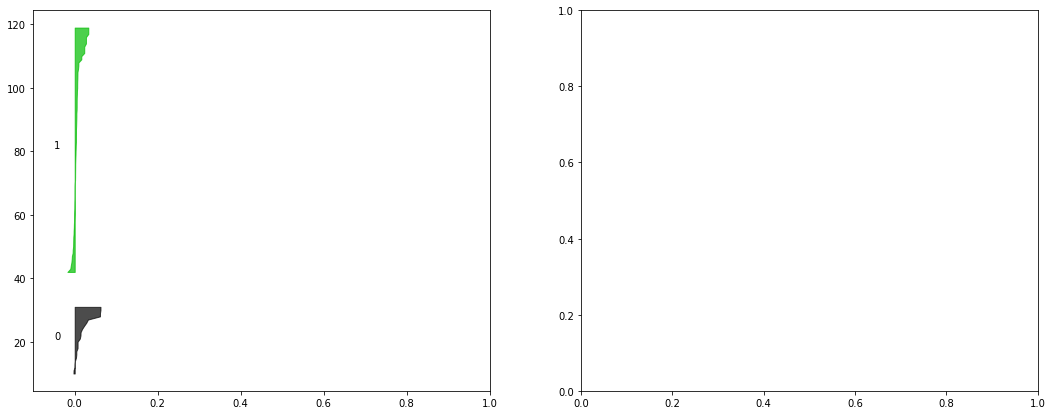

('For n_clusters =', 3, 'The average silhouette_score is :', 0.011022905608262502)


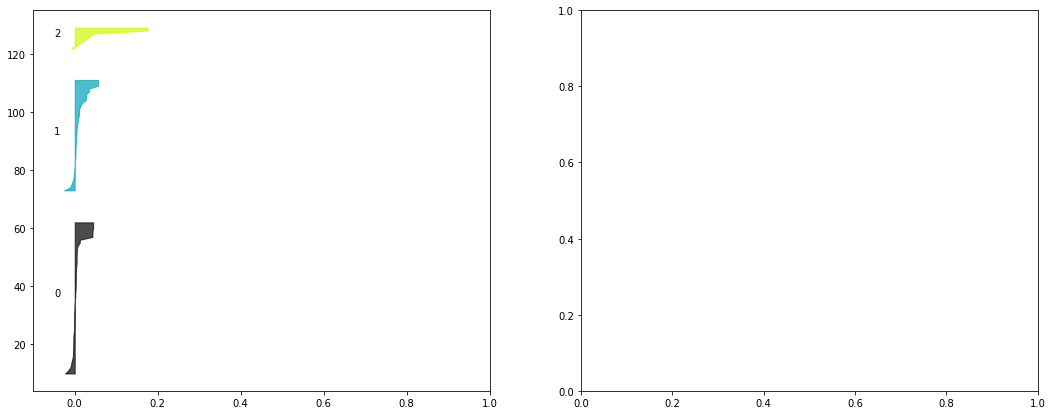

('For n_clusters =', 4, 'The average silhouette_score is :', 0.016528258238782609)


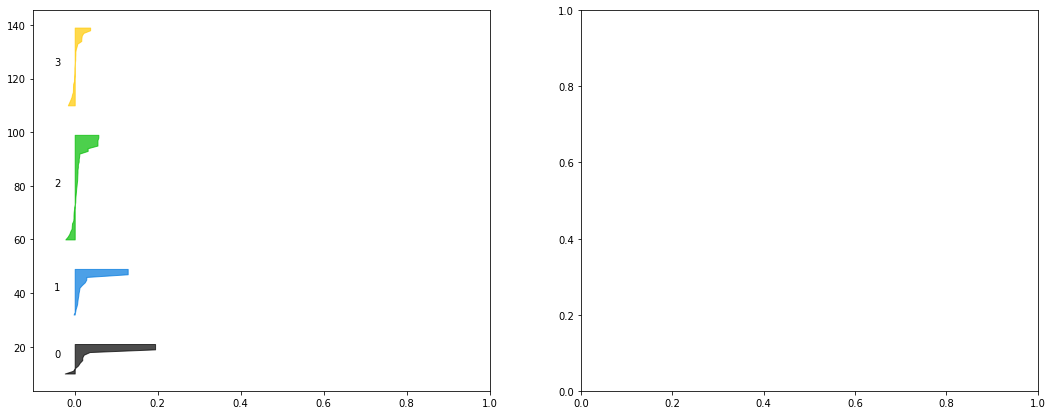

('For n_clusters =', 5, 'The average silhouette_score is :', 0.02115815057038066)


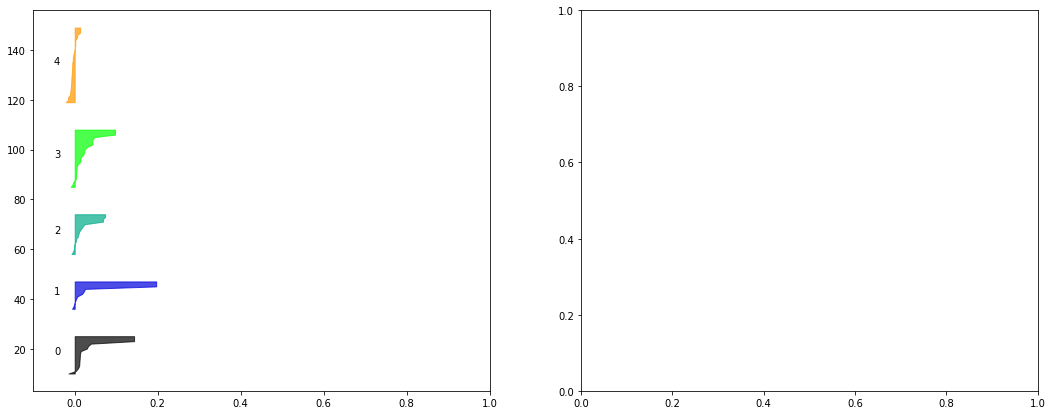

('For n_clusters =', 6, 'The average silhouette_score is :', 0.021580561023297154)


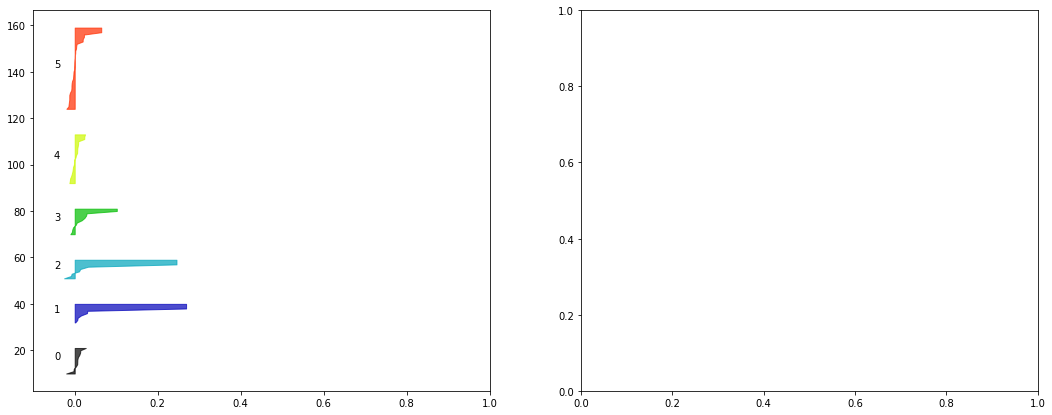

In [116]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1, verbose=False)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
    plt.show()

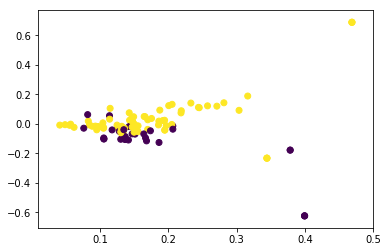

In [117]:
model = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=100, random_state=SEED, tol=0.0)
svd = model.fit_transform(X)
pl.figure('K-means')
pl.scatter(svd[:, 0], svd[:, 1], c=km.labels_)
pl.show()

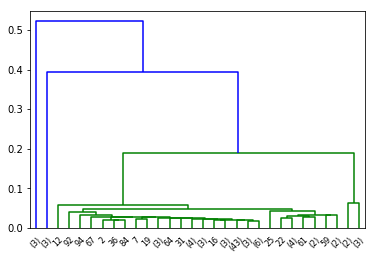

In [118]:
Z = linkage(svd, 'single')
dendrogram(Z,  leaf_font_size=8, truncate_mode='lastp', p=30, orientation='top')
plt.show()

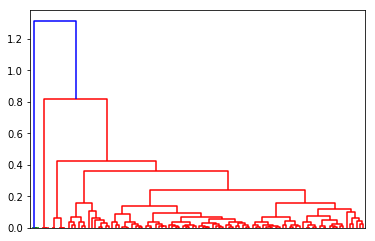

In [119]:
Z = linkage(svd, 'complete')
dendrogram(Z,  leaf_font_size=8, truncate_mode='lastp', p=100, orientation='top', no_labels=True)
plt.show()

In [120]:
N_clusters = 3

Z = AgglomerativeClustering(n_clusters=N_clusters, linkage="complete")
print("clustering...")
t0 = time()
Z.fit_predict(X.toarray())
print("done in %0.3fs" % (time() - t0))    

clustering...
done in 0.005s


In [123]:
import numbers

print("Top terms per cluster:")

avgs = [0] * N_clusters
counts = [0] * N_clusters

terms = vectorizer.get_feature_names()

# Calculate average tf-idf values for each cluster
for i in range(N_clusters):
    for j in range(len(tweets)):
        if Z.labels_[j] == i:
            if isinstance(avgs[i], numbers.Number):
                avgs[i] = X[j].toarray()
            else:
                avgs[i] += X[j].toarray()
            counts[i] += 1
            
for i in range(len(avgs)):
    avgs[i] = avgs[i] / counts[i]
    
avgs = np.asarray(avgs).argsort()[:, 0, ::-1]

for i in range(N_clusters):
    print("Cluster %d:" % i)
    for j in avgs[i, :10]:
        print(' %s' % terms[j])
    count = 0
    for j in range(len(tweets)):
        if Z.labels_[j] == i:
            count += 1
            print('{}: '.format(count))
            print(tweets[j])
            print("\n")

Top terms per cluster:
Cluster 0:
 rt
 http
 trump
 hi
 mueller
 amp
 robert
 thi
 real
 ha
1: 
RT @SethAbramson: Dammit if the last paragraph of this breaking news doesn't imply that the Trump administration deliberately burned our al…


2: 
RT @renzhiqiang2017: Trump is in trouble.On his first anniversary, his government is closing.He now lacks enough supporters to help him pas…


3: 
RT @SusanNow3: Women can stop Trump. 
Women will stop trump.


4: 
RT @RWPUSA: I am fed up with these scumbags slandering Robert Mueller, a brave and patriotic American.

 https://t.co/xd3MVZLnGp


5: 
If America has rejected God we are following the lead the likes of Falwell, Graham, Jeffress and Perkins. https://t.co/Fk3V484Fnl


6: 
RT @SethAbramson: Dammit if the last paragraph of this breaking news doesn't imply that the Trump administration deliberately burned our al…


7: 
RT @thehill: Trump lawyers researching decades-old court case in attempt to avoid Mueller interview: report https://t.co/EJCX